### Load Helper functions and HOGTransformer class
%load ml_helper/ml_helper.py

In [22]:
# %load ml_helper/ml_helper.py
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import numpy as np
import keras
import tensorflow as tf
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from skimage.feature import hog
from datetime import datetime
import logging
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

def today_date():
    return f'{datetime.today().month}.{datetime.today().day}.{datetime.today().year}'

def class_0_accuracy(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    total_samples_per_class = cm.sum(axis=1)
    accuracies_per_class = cm.diagonal() / total_samples_per_class
    class_0_accuracy = accuracies_per_class[0]
    return class_0_accuracy

def class_1_accuracy(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    total_samples_per_class = cm.sum(axis=1)
    accuracies_per_class = cm.diagonal() / total_samples_per_class
    class_1_accuracy = accuracies_per_class[1]
    return class_1_accuracy

def get_model_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    total_samples_per_class = cm.sum(axis=1)
    accuracies_per_class = cm.diagonal() / total_samples_per_class

    class_0_accuracy = accuracies_per_class[0]
    class_1_accuracy = accuracies_per_class[1]

    metrics = (acc, prec, recall, f1, roc, class_0_accuracy, class_1_accuracy)
    return metrics

def create_explainable_hog(df_hog, img_scale, weights, threshold, index):
    threshold_mask = np.percentile(weights, threshold)
    high_weight_mask = weights > threshold_mask
    filtered_weights = np.where(high_weight_mask, weights, 0).reshape(-1)
    
    ex_img = df_hog['hog_img'][index].flatten()

    for i in range(len(ex_img)):
        if filtered_weights[i] == 0:
            ex_img[i] = 0
    
    return ex_img.reshape(img_scale, img_scale)

class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(8,8),
                 cells_per_block=(2,2)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        hog_X = []
        img_scale = X[0].shape[1]

        for x in X:
            hog_fd, _ = hog(
                image=np.array(x).reshape((img_scale, img_scale, 3)),
                orientations=self.orientations,
                pixels_per_cell=self.pixels_per_cell,
                cells_per_block=self.cells_per_block,
                visualize=True,
                channel_axis=2
            )
            hog_X.append(hog_fd)
        
        hog_X = np.array(hog_X)

        hog_wide_X = np.zeros((len(hog_X), hog_X[0].shape[0]))
        for indx in range(len(hog_X)):
            for feature in range(hog_X[0].shape[0]):
                hog_wide_X[indx][feature] = hog_X[indx][feature]
        
        return hog_wide_X
    
def hog_svm_hyperparameter_tester(img_df, param_grid, experiment_name, n_splits=3, seed=12172023):
    
    # preprocessed_img = PIL image converted to numpy image
    X, y = np.array(img_df['np_img'][:]), np.array(img_df['label'][:]).astype(int)

    log_file = './experiment_logs/{}_{}'.format(today_date(), experiment_name)

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s %(message)s')
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)

    random.seed(seed)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    scorers = {
        'roc_auc': make_scorer(roc_auc_score),
        'class_0_accuracy': make_scorer(class_0_accuracy),
        'class_1_accuracy': make_scorer(class_1_accuracy),
        'precision': make_scorer(precision_score),
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }

    # pipeline
    pipeline = Pipeline([
        ('HOG', HOGTransformer()),
        ('SVM', SVC())
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scorers,
        refit='roc_auc',
        cv=skf,
        verbose=2
    )

    grid_search.fit(X, y)

    cv_results = grid_search.cv_results_
    for i in range(len(cv_results['params'])):
        print('Parameters: {}'.format(cv_results['params'][i]))
        logging.info('Parameters: {}'.format(cv_results['params'][i]))
        for scorer in scorers:
            print('{}: {}'.format(scorer, cv_results[f'mean_test_{scorer}'][i]))
            logging.info('{}: {}'.format(scorer, cv_results[f'mean_test_{scorer}'][i]))
        print('\n'); logging.info('\n')
    
    print('Best parameters found: {}'.format(grid_search.best_params_))
    print('Best cross-validated ROC AUC Score: {}'.format(grid_search.best_score_))
    logging.info('Best parameters found: {}'.format(grid_search.best_params_))
    logging.info('Best cross-validated ROC AUC Score: {}'.format(grid_search.best_score_))

    try:
        file_handler.close()
    except Exception as e:
        print('Error shutting down the logging.\nError msg: {}'.format(e))
        pass

    return grid_search

### Constants

In [2]:
SEED = 172024
random.seed(SEED)

In [3]:
BASE_DIR_PATH = os.path.abspath(os.getcwd())
DATA_BASE_DIR = BASE_DIR_PATH + '/data/'

In [4]:
OG_CAR_BIKE_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/original'
OG_CAR_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/original/Car'
OG_BIKE_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/original/Bike'

CAR_BIKE_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/cleaned'
CAR_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/cleaned/Car'
BIKE_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/cleaned/Bike'

In [5]:
columns = ['id', 'pil_img', 'np_img', 'flat_img', 'hog_fd', 'hog_img', 'label']

array_hog_64 = np.load(CAR_BIKE_DIR + '/64/df_hog_64.npy', allow_pickle=True)
df_hog_64 = pd.DataFrame(array_hog_64, columns=columns)

Testing Framework with a simple hyperparameter grid

In [9]:
simple_param_grid_64 = {
    'HOG__orientations': list(range(6,9,3)),
    'HOG__pixels_per_cell': [(4,4)],
    'HOG__cells_per_block': [(2,2)],
    'SVM__C': [2.5],
    'SVM__gamma': ['scale'],
    'SVM__kernel': ['linear']
}
simple_param_grid_64

{'HOG__orientations': [6],
 'HOG__pixels_per_cell': [(4, 4)],
 'HOG__cells_per_block': [(2, 2)],
 'SVM__C': [2.5],
 'SVM__gamma': ['scale'],
 'SVM__kernel': ['linear']}

In [10]:
simple_grid_search_results_64 = hog_svm_hyperparameter_tester(
    img_df=df_hog_64,
    param_grid=simple_param_grid_64,
    experiment_name='svm_hog_64',
    n_splits=2,
    seed=SEED
)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END HOG__cells_per_block=(2, 2), HOG__orientations=6, HOG__pixels_per_cell=(4, 4), SVM__C=2.5, SVM__gamma=scale, SVM__kernel=linear; total time= 1.9min
[CV] END HOG__cells_per_block=(2, 2), HOG__orientations=6, HOG__pixels_per_cell=(4, 4), SVM__C=2.5, SVM__gamma=scale, SVM__kernel=linear; total time= 2.2min
Parameters: {'HOG__cells_per_block': (2, 2), 'HOG__orientations': 6, 'HOG__pixels_per_cell': (4, 4), 'SVM__C': 2.5, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}
roc_auc: 0.886
class_0_accuracy: 0.876
class_1_accuracy: 0.896
precision: 0.8784333476870079
accuracy: 0.886
recall: 0.896
f1: 0.8871263096806574


Best parameters found: {'HOG__cells_per_block': (2, 2), 'HOG__orientations': 6, 'HOG__pixels_per_cell': (4, 4), 'SVM__C': 2.5, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}
Best cross-validated ROC AUC Score: 0.886


In [11]:
simple_grid_search_results_64

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=172024, shuffle=True),
             estimator=Pipeline(steps=[('HOG', HOGTransformer()),
                                       ('SVM', SVC())]),
             param_grid={'HOG__cells_per_block': [(2, 2)],
                         'HOG__orientations': [6],
                         'HOG__pixels_per_cell': [(4, 4)], 'SVM__C': [2.5],
                         'SVM__gamma': ['scale'], 'SVM__kernel': ['linear']},
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'class_0_accuracy': make_scorer(class_0_accuracy),
                      'class_1_accuracy': make_scorer(class_1_accuracy),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)},
             verbose=2)

Trying larger pool of hyperparameters

In [12]:
param_grid_64 = {
    'HOG__orientations': list(range(6,15,3)),
    'HOG__pixels_per_cell': [(4,4), (8,8)],
    'HOG__cells_per_block': [(2,2), (4,4)],
    'SVM__C': [1, 2.5, 5],
    'SVM__gamma': ['scale', 'auto'],
    'SVM__kernel': ['linear']
}
param_grid_64

{'HOG__orientations': [6, 9, 12],
 'HOG__pixels_per_cell': [(4, 4), (8, 8)],
 'HOG__cells_per_block': [(2, 2), (4, 4)],
 'SVM__C': [1, 2.5, 5],
 'SVM__gamma': ['scale', 'auto'],
 'SVM__kernel': ['linear']}

In [13]:
grid_search_results_64 = hog_svm_hyperparameter_tester(
    img_df=df_hog_64,
    param_grid=param_grid_64,
    experiment_name='svm_hog_64',
    n_splits=2,
    seed=SEED
)

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV] END HOG__cells_per_block=(2, 2), HOG__orientations=6, HOG__pixels_per_cell=(4, 4), SVM__C=1, SVM__gamma=scale, SVM__kernel=linear; total time= 1.9min
[CV] END HOG__cells_per_block=(2, 2), HOG__orientations=6, HOG__pixels_per_cell=(4, 4), SVM__C=1, SVM__gamma=scale, SVM__kernel=linear; total time= 1.9min
[CV] END HOG__cells_per_block=(2, 2), HOG__orientations=6, HOG__pixels_per_cell=(4, 4), SVM__C=1, SVM__gamma=auto, SVM__kernel=linear; total time= 1.8min
[CV] END HOG__cells_per_block=(2, 2), HOG__orientations=6, HOG__pixels_per_cell=(4, 4), SVM__C=1, SVM__gamma=auto, SVM__kernel=linear; total time= 1.9min
[CV] END HOG__cells_per_block=(2, 2), HOG__orientations=6, HOG__pixels_per_cell=(4, 4), SVM__C=2.5, SVM__gamma=scale, SVM__kernel=linear; total time= 2.0min
[CV] END HOG__cells_per_block=(2, 2), HOG__orientations=6, HOG__pixels_per_cell=(4, 4), SVM__C=2.5, SVM__gamma=scale, SVM__kernel=linear; total time= 1.9min
[CV] E

Trying to optimize the best set of parameters found already

In [8]:
param_grid_64_v2 = {
    'HOG__orientations': [9],
    'HOG__pixels_per_cell': [(8,8), (16,16)],
    'HOG__cells_per_block': [(4,4), (8,8)],
    'SVM__C': list(np.arange(.5, 2.5, .5)),
    'SVM__gamma': ['scale'],
    'SVM__kernel': ['linear']
}
param_grid_64_v2

{'HOG__orientations': [9],
 'HOG__pixels_per_cell': [(8, 8), (16, 16)],
 'HOG__cells_per_block': [(4, 4), (8, 8)],
 'SVM__C': [0.5, 1.0, 1.5, 2.0],
 'SVM__gamma': ['scale'],
 'SVM__kernel': ['linear']}

In [9]:
grid_search_results_64_v2 = hog_svm_hyperparameter_tester(
    img_df=df_hog_64,
    param_grid=param_grid_64_v2,
    experiment_name='svm_hog_64_v2',
    n_splits=2,
    seed=SEED
)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END HOG__cells_per_block=(4, 4), HOG__orientations=9, HOG__pixels_per_cell=(8, 8), SVM__C=0.5, SVM__gamma=scale, SVM__kernel=linear; total time= 1.4min
[CV] END HOG__cells_per_block=(4, 4), HOG__orientations=9, HOG__pixels_per_cell=(8, 8), SVM__C=0.5, SVM__gamma=scale, SVM__kernel=linear; total time= 1.2min
[CV] END HOG__cells_per_block=(4, 4), HOG__orientations=9, HOG__pixels_per_cell=(8, 8), SVM__C=1.0, SVM__gamma=scale, SVM__kernel=linear; total time= 1.2min
[CV] END HOG__cells_per_block=(4, 4), HOG__orientations=9, HOG__pixels_per_cell=(8, 8), SVM__C=1.0, SVM__gamma=scale, SVM__kernel=linear; total time= 1.3min
[CV] END HOG__cells_per_block=(4, 4), HOG__orientations=9, HOG__pixels_per_cell=(8, 8), SVM__C=1.5, SVM__gamma=scale, SVM__kernel=linear; total time= 1.3min
[CV] END HOG__cells_per_block=(4, 4), HOG__orientations=9, HOG__pixels_per_cell=(8, 8), SVM__C=1.5, SVM__gamma=scale, SVM__kernel=linear; total time= 1.2m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Fram

Parameters: {'HOG__cells_per_block': (4, 4), 'HOG__orientations': 9, 'HOG__pixels_per_cell': (8, 8), 'SVM__C': 0.5, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}
roc_auc: 0.905
class_0_accuracy: 0.903
class_1_accuracy: 0.907
precision: 0.9034476463193322
accuracy: 0.905
recall: 0.907
f1: 0.9051823936519494


Parameters: {'HOG__cells_per_block': (4, 4), 'HOG__orientations': 9, 'HOG__pixels_per_cell': (8, 8), 'SVM__C': 1.0, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}
roc_auc: 0.9020000000000001
class_0_accuracy: 0.8985000000000001
class_1_accuracy: 0.9055
precision: 0.8992069408943166
accuracy: 0.902
recall: 0.9055
f1: 0.9023422759609618


Parameters: {'HOG__cells_per_block': (4, 4), 'HOG__orientations': 9, 'HOG__pixels_per_cell': (8, 8), 'SVM__C': 1.5, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}
roc_auc: 0.89925
class_0_accuracy: 0.901
class_1_accuracy: 0.8975
precision: 0.9006593205181914
accuracy: 0.89925
recall: 0.8975
f1: 0.8990723011987982


Parameters: {'HOG__cells_per_b

### Creating model with optimal parameters for 64x64 HOG features

Preprocessing

In [6]:
files = []
for f in sorted(os.listdir(CAR_DIR)):
    files.append([CAR_DIR + '/' + f, 0])
for f in sorted(os.listdir(BIKE_DIR)):
    files.append([BIKE_DIR + '/' + f, 1])
files = np.array(files)

In [7]:
df_img_files = pd.DataFrame(files, columns=['img_file', 'label'])

Feature engineering

In [9]:
def create_df_hog(df, img_scale, orientations, pixels_per_cell, cells_per_block, interpolation='lanczos'):
    records = []
    name = lambda label : 'Car' if label == 0 else 'Bike'
    for i in range(len(df)):
        img_file, label = df['img_file'][i], df['label'][i]
        # unique identifier
        id = f'{i}-{name(label)}'
        # PIL, np_img, flat_img
        img = image.load_img(img_file.strip(), target_size=(img_scale, img_scale), interpolation=interpolation)
        img_array = image.img_to_array(img)
        x = np.expand_dims(img_array, axis=0)
        x = preprocess_input(x)
        flat_img = x.flatten()
        # HOG
        hog_fd, hog_img = hog(
            image=np.array(img),
            orientations=9,
            pixels_per_cell=(8,8),
            cells_per_block=(2,2),
            visualize=True,
            channel_axis=2
        )
        record = np.array([id, img, x, flat_img, hog_fd, hog_img, label], dtype=object)
        records.append(record)
    columns=['id', 'pil_img', 'np_img', 'flat_img', 'hog_fd', 'hog_img', 'label']
    return pd.DataFrame(data=records, columns=columns)

In [11]:
df_hog_64_v2 = create_df_hog(
    df=df_img_files,
    img_scale=64,
    orientations=9,
    pixels_per_cell=(8,8),
    cells_per_block=(2,2),
    interpolation='lanczos'
)

In [12]:
df_hog_64_v2.head(2)

,id,pil_img,np_img,flat_img,hog_fd,hog_img,label
0,0-Bike,<PIL.Image.Image image mode=RGB size=64x64 at ...,"[[[[ 0.39607847 -0.7411765 -0.7019608 ], [ 0....","[0.39607847, -0.7411765, -0.7019608, 0.3882353...","[0.021065038310983747, 0.0, 0.0, 0.00379861752...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,1-Bike,<PIL.Image.Image image mode=RGB size=64x64 at ...,"[[[[0.9764706 0.8901961 0.7254902], [0.9764706...","[0.9764706, 0.8901961, 0.7254902, 0.9764706, 0...","[0.31825621275498656, 0.04297539893275055, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [13]:
np.save(file=CAR_BIKE_DIR + '/64/df_hog_64_v2.npy', arr=df_hog_64_v2.to_numpy(), allow_pickle=True)

In [5]:
columns = ['id', 'pil_img', 'np_img', 'flat_img', 'hog_fd', 'hog_img', 'label']

array_hog_64_v2 = np.load(file=CAR_BIKE_DIR + '/64/df_hog_64_v2.npy', allow_pickle=True)
df_hog_64_v2 = pd.DataFrame(array_hog_64_v2, columns=columns)

In [7]:
hog_records = []

for i in range(len(df_hog_64_v2)):
    hog_img, label = preprocess_input(df_hog_64_v2['hog_img'][i].flatten()), df_hog_64_v2['label'][i]
    hog_records.append(np.array([hog_img, label], dtype=object))

hog_records = np.array(hog_records)

hog_X, hog_y = hog_records[:, 0], hog_records[:, 1]

hog_y = hog_y.astype(int)
hog_wide_X = np.zeros((len(hog_X), hog_X[0].shape[0]))
for indx in range(len(hog_X)):
    for feature in range(hog_X[0].shape[0]):
        hog_wide_X[indx][feature] = hog_X[indx][feature]

In [8]:
hog_wide_X.shape, hog_y.shape

((4000, 4096), (4000,))

In [9]:
hog_wide_X[0].shape

(4096,)

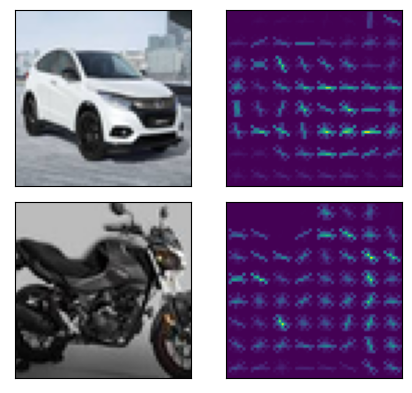

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

ax[0, 0].imshow(df_hog_64_v2['pil_img'][3])
ax[0, 1].imshow(df_hog_64_v2['hog_img'][3])
ax[1, 0].imshow(df_hog_64_v2['pil_img'][2000])
ax[1, 1].imshow(df_hog_64_v2['hog_img'][2000])

# remove tick labels
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticks([])  
        ax[i, j].set_yticks([])

fig.subplots_adjust(hspace=0)

plt.show()

In [14]:
svm_hog_64 = SVC(C=1, kernel='linear', gamma='scale')

In [15]:
svm_hog_64.fit(hog_wide_X, hog_y)

SVC(C=1, kernel='linear')

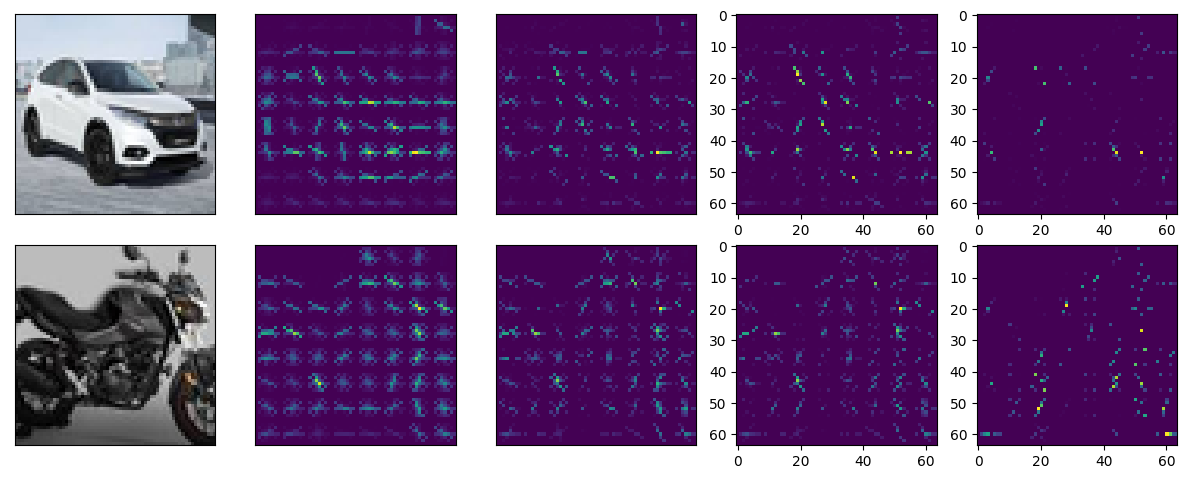

In [61]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

ax[0, 0].imshow(df_hog_64_v2['pil_img'][3])
ax[0, 1].imshow(df_hog_64_v2['hog_img'][3])
ax[0, 2].imshow(create_explainable_hog(df_hog_64_v2, 64, svm_hog_64.coef_, 50, 3))
ax[0, 3].imshow(create_explainable_hog(df_hog_64_v2, 64, svm_hog_64.coef_, 85, 3))
ax[0, 4].imshow(create_explainable_hog(df_hog_64_v2, 64, svm_hog_64.coef_, 95, 3))
ax[1, 0].imshow(df_hog_64_v2['pil_img'][2000])
ax[1, 1].imshow(df_hog_64_v2['hog_img'][2000])
ax[1, 2].imshow(create_explainable_hog(df_hog_64_v2, 64, svm_hog_64.coef_, 50, 2000))
ax[1, 3].imshow(create_explainable_hog(df_hog_64_v2, 64, svm_hog_64.coef_, 85, 2000))
ax[1, 4].imshow(create_explainable_hog(df_hog_64_v2, 64, svm_hog_64.coef_, 95, 2000))

# remove tick labels
for i in range(2):
    for j in range(3):
        ax[i, j].set_xticks([])  
        ax[i, j].set_yticks([])


fig.subplots_adjust(hspace=0)
plt.show()